## CCD and TED

In [1]:
import gzip
import json
import os
import sys
from os import PathLike, path
from paramiko.client import SSHClient, AutoAddPolicy
from typing import List, Tuple, TypeAlias, Generator, Iterable
from huggingface_hub import list_datasets
from datasets import load_dataset, load_dataset_builder
from transformers import AutoTokenizer
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from functools import wraps, reduce
import shutil
from util import load_jsonl, get_samples, get_samples_greedy, gpto_get_samples, gpto_get_samples_greedy, tokenize_code, get_edit_distance_distribution_star, calculate_ratio, openai_get_samples_instruct, openai_get_samples_greedy_instruct

Tokens: TypeAlias = List[int]

alpha: float = 0.05
xi: float = 0.01
max_length: int = 100

conf_list = [
    # # GPT-4o
    # {
    #     "identifier": "Defect4J gpt-4o 2024-08-06",
    #     "greedy_path": "data/gpt-4o/defects4j/greedy/candidates_defects4j_instruct_openai-chatcompletion_model_name=gpt-4o-2024-08-06_temperature=0.0_n_samples=1.jsonl",
    #     "multiple_path": "data/gpt-4o/defects4j/multiple/candidates_defects4j_instruct_openai-chatcompletion_model_name=gpt-4o-2024-08-06_n_samples=10_temperature=1.0.jsonl",
    #     "method": "gpt-4o",
    #     "tokenizer": "Xenova/gpt-4o"
    # },
    # {
    #     "identifier": "GitBugJava gpt-4o 2024-08-06",
    #     "greedy_path": "data/gpt-4o/gitbug-java/greedy/candidates_gitbugjava_instruct_openai-chatcompletion_model_name=gpt-4o-2024-08-06_temperature=0.0_n_samples=1.jsonl",
    #     "multiple_path": "data/gpt-4o/gitbug-java/multiple/candidates_gitbugjava_instruct_openai-chatcompletion_model_name=gpt-4o-2024-08-06_n_samples=10_temperature=1.0.jsonl",
    #     "method": "gpt-4o",
    #     "tokenizer": "Xenova/gpt-4o"
    # },
    # # GitBugJava starcoder
    # {
    #     "identifier": "GitBugJava starcoder",
    #     "greedy_path": "data/starcoder/gitbug-java/greedy/candidates_GitBugJava_fill-in-the-middle_starcoder_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/starcoder/gitbug-java/multiple/candidates_GitBugJava_fill-in-the-middle_starcoder_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "bigcode/starcoder"
    # },
    # {
    #     "identifier": "GitBugJava starcoderbase-1b",
    #     "greedy_path": "data/starcoderbase-1b/gitbug-java/greedy/candidates_GitBugJava_fill-in-the-middle_starcoderbase-1b_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/starcoderbase-1b/gitbug-java/multiple/candidates_GitBugJava_fill-in-the-middle_starcoderbase-1b_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "bigcode/starcoderbase-1b"
    # },
    # {
    #     "identifier": "GitBugJava starcoderplus",
    #     "greedy_path": "data/starcoderplus/gitbug-java/greedy/candidates_GitBugJava_fill-in-the-middle_starcoderplus_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/starcoderplus/gitbug-java/multiple/candidates_GitBugJava_fill-in-the-middle_starcoderplus_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "bigcode/starcoderplus"
    # },
    # {
    #     "identifier": "GitBugJava starcoder t=0.8",
    #     "greedy_path": "data/starcoder/gitbug-java/greedy/candidates_GitBugJava_fill-in-the-middle_starcoder_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/starcoder/gitbug-java/multiple/candidates_GitBugJava_fill-in-the-middle_starcoder_temperature=0.8_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "bigcode/starcoder"
    # },
    # # HumanEvalJava starcoder
    # {
    #     "identifier": "HumanEvalJava starcoder",
    #     "greedy_path": "data/starcoder/humaneval-java/greedy/candidates_HumanEvalJava_fill-in-the-middle_starcoder_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/starcoder/humaneval-java/multiple/candidates_HumanEvalJava_fill-in-the-middle_starcoder_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "bigcode/starcoder"
    # },
    # {
    #     "identifier": "HumanEvalJava starcoderbase-1b",
    #     "greedy_path": "data/starcoderbase-1b/humaneval-java/greedy/candidates_HumanEvalJava_fill-in-the-middle_starcoderbase-1b_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/starcoderbase-1b/humaneval-java/multiple/candidates_HumanEvalJava_fill-in-the-middle_starcoderbase-1b_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "bigcode/starcoderbase-1b"
    # },
    # {
    #     "identifier": "HumanEvalJava starcoderplus",
    #     "greedy_path": "data/starcoderplus/humaneval-java/greedy/candidates_HumanEvalJava_fill-in-the-middle_starcoderplus_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/starcoderplus/humaneval-java/multiple/candidates_HumanEvalJava_fill-in-the-middle_starcoderplus_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "bigcode/starcoderplus"
    # },
    # {
    #     "identifier": "HumanEvalJava starcoder t=0.8",
    #     "greedy_path": "data/starcoder/humaneval-java/greedy/candidates_HumanEvalJava_fill-in-the-middle_starcoder_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/starcoder/humaneval-java/multiple/candidates_HumanEvalJava_fill-in-the-middle_starcoder_temperature=0.8_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "bigcode/starcoder"
    # },
    # # Defects4J starcoder
    # {
    #     "identifier": "Defects4J starcoder",
    #     "greedy_path": "data/starcoder/defects4j/greedy/candidates_Defects4J_fill-in-the-middle_starcoder_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/starcoder/defects4j/multiple/candidates_Defects4J_fill-in-the-middle_starcoder_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "bigcode/starcoder"
    # },
    # {
    #     "identifier": "Defects4J starcoderbase-1b",
    #     "greedy_path": "data/starcoderbase-1b/defects4j/greedy/candidates_Defects4J_fill-in-the-middle_starcoderbase-1b_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/starcoderbase-1b/defects4j/multiple/candidates_Defects4J_fill-in-the-middle_starcoderbase-1b_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "bigcode/starcoderbase-1b"
    # },
    # {
    #     "identifier": "Defects4J starcoderplus",
    #     "greedy_path": "data/starcoderplus/defects4j/greedy/candidates_Defects4J_fill-in-the-middle_starcoderplus_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/starcoderplus/defects4j/multiple/candidates_Defects4J_fill-in-the-middle_starcoderplus_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "bigcode/starcoderplus"
    # },
    # {
    #     "identifier": "Defects4J starcoder t=0.8",
    #     "greedy_path": "data/starcoder/defects4j/greedy/candidates_Defects4J_fill-in-the-middle_starcoder_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/starcoder/defects4j/multiple/candidates_Defects4J_fill-in-the-middle_starcoder_temperature=0.8_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "bigcode/starcoder"
    # },
    # # TODO: Add the codellama-7b models
    # # Defects4J codellama-7b
    # {
    #     "identifier": "Defects4J codellama-7b",
    #     "greedy_path": "data/codellama-7b/defects4j/greedy/candidates_Defects4J_fill-in-the-middle_codellama-7b_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/codellama-7b/defects4j/multiple/candidates_Defects4J_fill-in-the-middle_codellama-7b_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "codellama/CodeLlama-7b-hf"
    # },
    # # HumanEvalJava codellama-7b
    # {
    #     "identifier": "HumanEvalJava codellama-7b",
    #     "greedy_path": "data/codellama-7b/humaneval-java/greedy/candidates_HumanEvalJava_fill-in-the-middle_codellama-7b_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/codellama-7b/humaneval-java/multiple/candidates_HumanEvalJava_fill-in-the-middle_codellama-7b_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "codellama/CodeLlama-7b-hf"
    # },
    # # GitBugJava codellama-7b
    # {
    #     "identifier": "GitBugJava codellama-7b",
    #     "greedy_path": "data/codellama-7b/gitbug-java/greedy/candidates_GitBugJava_fill-in-the-middle_codellama-7b_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/codellama-7b/gitbug-java/multiple/candidates_GitBugJava_fill-in-the-middle_codellama-7b_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "codellama/CodeLlama-7b-hf"
    # },
    # # HumanEvalJava codellama-7b sigonly t=0.8,
    # {
    #     "identifier": "HumanEvalJava codellama-7b sigonly t=0.8",
    #     "greedy_path": "data/codellama-7b/humaneval-java/greedy/candidates_HumanEvalJava_sigonly_codellama-7b_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/codellama-7b/humaneval-java/multiple/candidates_HumanEvalJava_sigonly_codellama-7b_temperature=0.8_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "codellama",
    #     "tokenizer": "codellama/CodeLlama-7b-hf",
    # },
    # # Defects4J codellama-7b sigonly t=0.8,
    # {
    #     "identifier": "Defects4J codellama-7b sigonly t=0.8",
    #     "greedy_path": "data/codellama-7b/defects4j/greedy/candidates_Defects4J_sigonly_codellama-7b_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/codellama-7b/defects4j/multiple/candidates_Defects4J_sigonly_codellama-7b_temperature=0.8_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "codellama",
    #     "tokenizer": "codellama/CodeLlama-7b-hf",
    # },
    # # GitBugJava codellama-7b sigonly t=0.8,
    # {
    #     "identifier": "GitBugJava codellama-7b sigonly t=0.8",
    #     "greedy_path": "data/codellama-7b/gitbug-java/greedy/candidates_GitBugJava_sigonly_codellama-7b_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/codellama-7b/gitbug-java/multiple/candidates_GitBugJava_sigonly_codellama-7b_temperature=0.8_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "codellama",
    #     "tokenizer": "codellama/CodeLlama-7b-hf",
    # },

    # ====================================================
    # Berzelius data
    # ====================================================
    # {
    #     "identifier": "HumanEvalJava gpt-4o-mini sigonly-instruct",
    #     "greedy_path": "data/humaneval-java/gpt-4o-mini/greedy/candidates_HumanEvalJava_sigonly-instruct_openai-chatcompletion_model_name=gpt-4o-mini_generation_strategy=beam_search_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/humaneval-java/gpt-4o-mini/multiple/candidates_HumanEvalJava_sigonly-instruct_openai-chatcompletion_model_name=gpt-4o-mini_max_length=4096_temperature=0.8_generation_strategy=sampling_num_return_sequences=50.jsonl",
    #     "method": "openai-instruct",
    #     "tokenizer": "Xenova/gpt-4o",
    # },
    # {
    #     "identifier": "GitBugJava gpt-4o-mini sigonly-instruct",
    #     "greedy_path": "data/gitbug-java/gpt-4o-mini/greedy/candidates_GitBugJava_sigonly-instruct_openai-chatcompletion_model_name=gpt-4o-mini_generation_strategy=beam_search_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/gitbug-java/gpt-4o-mini/multiple/candidates_GitBugJava_sigonly-instruct_openai-chatcompletion_model_name=gpt-4o-mini_max_length=4096_temperature=0.8_generation_strategy=sampling_num_return_sequences=50.jsonl",
    #     "method": "openai-instruct",
    #     "tokenizer": "Xenova/gpt-4o",
    # },
    # {
    #     "identifier": "Defects4J gpt-4o-mini sigonly-instruct",
    #     "greedy_path": "data/defects4j/gpt-4o-mini/greedy/candidates_Defects4J_sigonly-instruct_openai-chatcompletion_model_name=gpt-4o-mini_generation_strategy=beam_search_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/defects4j/gpt-4o-mini/multiple/candidates_Defects4J_sigonly-instruct_openai-chatcompletion_model_name=gpt-4o-mini_max_length=4096_temperature=0.8_generation_strategy=sampling_num_return_sequences=50.jsonl",
    #     "method": "openai-instruct",
    #     "tokenizer": "Xenova/gpt-4o",
    # },
    {
        "identifier": "HumanEvalJava",
        "greedy_path": "data/humaneval-java/meta-llama/CodeLlama-7b-Instruct-hf/greedy/candidates_HumanEvalJava_sigonly-instruct_codellama-instruct_model_name=meta-llama:CodeLlama-7b-Instruct-hf_max_length=4096_generation_strategy=beam_search_num_return_sequences=1.jsonl",
        "multiple_path": "data/humaneval-java/candidates_HumanEvalJava_sigonly-instruct_codellama-instruct_model_name=meta-llama:CodeLlama-7b-Instruct-hf_max_length=4096_temperature=0.05_generation_strategy=sampling_num_return_sequences=10_all.jsonl",
        "method": "huggingface",
        "tokenizer": "meta-llama/CodeLlama-7b-hf",
    },
    {
        "identifier": "GitBugJava",
        "greedy_path": "data/gitbug-java/meta-llama/CodeLlama-7b-Instruct-hf/greedy/candidates_GitBugJava_sigonly-instruct_codellama-instruct_model_name=meta-llama:CodeLlama-7b-Instruct-hf_max_length=4096_generation_strategy=beam_search_num_return_sequences=1.jsonl",
        "multiple_path": "data/gitbug-java/candidates_GitBugJava_sigonly-instruct_codellama-instruct_model_name=meta-llama:CodeLlama-7b-Instruct-hf_max_length=4096_temperature=0.05_generation_strategy=sampling_num_return_sequences=10_all.jsonl",
        "method": "huggingface",
        "tokenizer": "meta-llama/CodeLlama-7b-hf",
    },
    {
        "identifier": "Defects4J",
        "greedy_path": "data/defects4j/meta-llama/CodeLlama-7b-Instruct-hf/greedy/candidates_Defects4J_sigonly-instruct_codellama-instruct_model_name=meta-llama:CodeLlama-7b-Instruct-hf_max_length=4096_generation_strategy=beam_search_num_return_sequences=1.jsonl",
        "multiple_path": "data/defects4j/candidates_Defects4J_sigonly-instruct_codellama-instruct_model_name=meta-llama:CodeLlama-7b-Instruct-hf_max_length=4096_temperature=0.05_generation_strategy=sampling_num_return_sequences=10_all.jsonl",
        "method": "huggingface",
        "tokenizer": "meta-llama/CodeLlama-7b-hf",
    },
]
# Fast filter
# FILTER_FUN = lambda conf: "codellama/CodeLlama-7b-hf" in conf["tokenizer"]
# FILTER_FUN = lambda conf: "starcoder" in conf["identifier"].split() and "HumanEvalJava" in conf["identifier"].split()
# conf_list = list(filter(FILTER_FUN, conf_list))

skipped_list = []
invalid_multiple_candidates_list = []
invalid_greedy_candidates_list = []
peaks_list = []
dists_list = []
for conf in conf_list:
    tokenizer = AutoTokenizer.from_pretrained(conf["tokenizer"])
    run_identifier = conf["identifier"]
    greedy_path = conf["greedy_path"]
    multiple_path = conf["multiple_path"]
    # Load the multiple generation data
    if multiple_path.endswith(".gz"):
        data = load_jsonl(multiple_path, gzip.open)
    else:
        data = load_jsonl(multiple_path)
    multiple_samples_taskset = data

    # Load the greedy generation data
    if greedy_path.endswith(".gz"):
        data = load_jsonl(greedy_path, gzip.open)
    else:
        data = load_jsonl(greedy_path)
    greedy_samples_taskset = data
    
    # dataset speficic functions
    match conf["method"]:
        case "openai-instruct":
            samples_fun, greedy_sample_fun = openai_get_samples_instruct, openai_get_samples_greedy_instruct
        case "huggingface":
            samples_fun, greedy_sample_fun = get_samples, get_samples_greedy
        case _:
            raise ValueError(f"Unknown method: {conf['method']}")
    
    # get greedy samples
    greedy_samples_taskset_map = {s["identifier"]: greedy_sample_fun(s) for s in greedy_samples_taskset}
    
    n_samples = len(multiple_samples_taskset)
    Skipped = [False for _ in range(n_samples)]
    Dists = [None for _ in range(n_samples)]
    Peaks = [None for _ in range(n_samples)]
    InvalidMultipleSamples = [0 for _ in range(n_samples)]
    InvalidGreedySamples = [0 for _ in range(n_samples)]
    for i, task in enumerate(multiple_samples_taskset):
        task_identifier = task["identifier"]
        # Tokenize the samples
        samples = samples_fun(task)
        if not samples:
            Skipped[i] = "No samples generated"
            continue
        correct_samples = list(filter(None, samples))
        InvalidMultipleSamples[i] = len(samples) - len(correct_samples)
        if not correct_samples:
            Skipped[i] = "No valid samples"
            continue
        samples: List[Tokens] = [
            tokenize_code(s, tokenizer, max_length) for s in samples
        ]
        # Tokenize the greedy sample
        if task_identifier not in greedy_samples_taskset_map:
            Skipped[i] = "No corresponding greedy sample"
            continue
        gready_sample_str = greedy_samples_taskset_map[task_identifier]
        if not gready_sample_str:
            InvalidGreedySamples[i] = 1
            Skipped[i] = "Invalid greedy sample"
            continue
        gready_sample: Tokens = tokenize_code(gready_sample_str, tokenizer, max_length)
        # Calculate the edit distance distribution
        dist, ml = get_edit_distance_distribution_star(samples, gready_sample)
        Dists[i] = dist
        peak = calculate_ratio(dist, alpha * ml)
        Peaks[i] = peak

    # Add results to the lists
    skipped_list.append(Skipped)
    dists_list.append(Dists)
    peaks_list.append(Peaks)
    invalid_multiple_candidates_list.append(InvalidMultipleSamples)
    invalid_greedy_candidates_list.append(InvalidGreedySamples)



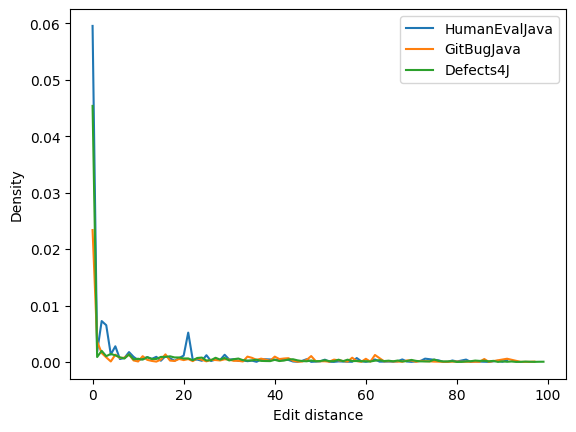

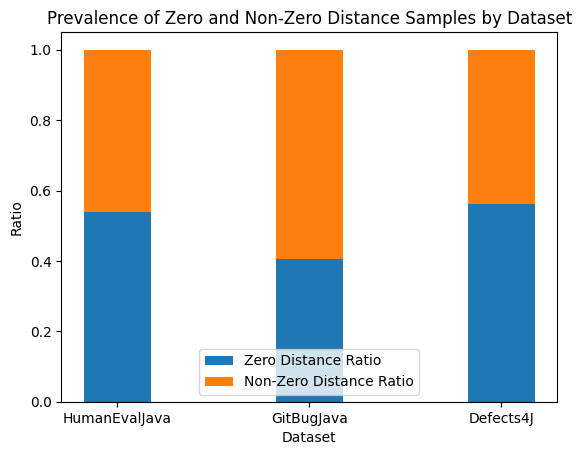

In [2]:
# We have a list of identifiers and a list of edit distances
# We want a line plot of multiple lines
# - x-axis is the edit distance
# - y-axis is the ratio of samples that have an equal edit-distance
from functools import reduce
import matplotlib.pyplot as plt
from collections import Counter
from typing import List, Tuple
import numpy as np

identifiers = [e["identifier"] for e in conf_list]
for i, dists in enumerate(dists_list):
    d_full = filter(None, dists)  # Remove None values
    d_full = reduce(lambda x, y: x + y, d_full)  # Flatten the list
    d_full = list(d_full)
    total = sum(d_full)
    count = Counter(d_full)
    x, y = zip(*sorted(count.items(), key=lambda x: x[0]))
    y = [c / total for c in y]
    plt.plot(x, y, label=identifiers[i])
plt.xlabel("Edit distance")
plt.ylabel("Density")
plt.legend()

plt.show()

# Generate a bar chart showing the prevalence of zero distance samples relative to the total number of samples

identifiers = [e["identifier"] for e in conf_list]
index = np.arange(len(identifiers))  # The label locations

zero_distance_ratios = []
non_zero_distance_ratios = []

for i, dists in enumerate(dists_list):
    d_full = filter(None, dists)  # Remove None values
    d_full = reduce(lambda x, y: x + y, d_full)  # Flatten the list
    d_full = list(d_full)
    count = Counter(d_full)
    
    zero_distance = count.get(0, 0)
    total_samples = sum(count.values())
    
    zero_distance_ratio = zero_distance / total_samples
    non_zero_distance_ratio = 1 - zero_distance_ratio
    
    zero_distance_ratios.append(zero_distance_ratio)
    non_zero_distance_ratios.append(non_zero_distance_ratio)

fig, ax = plt.subplots()
bar_width = 0.35

p1 = ax.bar(index, zero_distance_ratios, bar_width, label='Zero Distance Ratio')
p2 = ax.bar(index, non_zero_distance_ratios, bar_width, bottom=zero_distance_ratios, label='Non-Zero Distance Ratio')

ax.set_xlabel('Dataset')
ax.set_ylabel('Ratio')
ax.set_title('Prevalence of Zero and Non-Zero Distance Samples by Dataset')
ax.set_xticks(index)
ax.set_xticklabels(identifiers)
ax.legend()

plt.show()

In [9]:
n_data = len(dists_list)
n_bugs = set(len(e) for e in dists_list)
n_samples = len(dists_list[0][0])
n_data, n_bugs, n_samples

(3, {163, 199, 835}, 1)

In [10]:
# Number of invalid samples (could not be transformed and tokenized)
i = 2
n_tasks = len(dists_list[i])
n_no_samples = len(list(filter(lambda e: e == "No samples generated", skipped_list[i])))
n_tasks - n_no_samples, sum(invalid_multiple_candidates_list[i])

(492, 23)

In [11]:
# Skip reason counter
[Counter(e) for e in skipped_list]

[Counter({False: 163}),
 Counter({'No samples generated': 104, False: 95}),
 Counter({False: 464,
          'No samples generated': 343,
          'No valid samples': 23,
          'Invalid greedy sample': 5})]